# Comparing Total Gas Masses Between Analyses

This notebook measures gas masses for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

The XXL, LoCuSS, and Lovisari samples all have gas mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper).

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
xxl_colour = samp_colours[samp_colours['samp_name'] == 'xxl'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
xxl_cosmo = WMAP9
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [5]:
xxlgc100 = pd.read_csv("sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [6]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:05<08:52,  5.43s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:13<11:12,  6.94s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:35<06:56,  5.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:40<06:44,  4.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:45<06:44,  5.06s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  32%|██████████████▌                              | 32/99 [04:14<14:25, 12.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0404965201, associated with source XLSSC-54
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
Setting up Galaxy Clusters:  33%|███████████████                              | 33/99 [04:19<11:41, 10.63s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0780452501, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0109520401, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associ

Setting up Galaxy Clusters:  45%|████████████████████▍                        | 45/99 [07:41<13:24, 14.90s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-89 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  46%|████████████████████▉                        | 46/99 [07:50<11:41, 13.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0677600133 and is very close to the user supplied coordinates of XLSSC-104. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124:

Setting up Galaxy Clusters:  62%|███████████████████████████▋                 | 61/99 [09:01<02:08,  3.38s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-518 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|████████████████████████████▏                | 62/99 [09:04<01:57,  3.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0604873944, associated with source XLSSC-531
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-531 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  77%|██████████████████████████████████▌          | 76/99 [10:04<01:33,  4.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-505 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  78%|███████████████████████████████████          | 77/99 [10:07<01:21,  3.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677720134, associated with source XLSSC-506
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-506 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  93%|█████████████████████████████████████████▊   | 92/99 [11:08<00:34,  4.89s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-541 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  94%|██████████████████████████████████████████▎  | 93/99 [11:13<00:28,  4.76s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-508 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  95%|██████████████████████████████████████████▋  | 94/99 [11:23<00:31,  6.32s/it]/mnt/pact/dt

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [7]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [01:35<04:29,  8.43s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [02:26<05:07, 11.37s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [02:47<02:52,  7.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does not appear to have any XMM data, and

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|████████████████████████████████████████     | 41/46 [05:12<01:04, 12.80s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell2261 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fit

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [9]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [10]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=False, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████▌                     | 60/120 [08:09<05:33,  5.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|█████████████████████▊                     | 61/120 [08:21<07:30,  7.63s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTr

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G080.38-33.20 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G080.38-33.20 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  29%|████████████▊                               | 35/120 [04:50<07:46,  5.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G093.91+34.90 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warning

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690201/0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690201/0502690201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0112230501/0112230501_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0112230501/0112230501_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarnin

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0105660101 and is very close to the user supplied coordinates of G252.96-56.05. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G252.96-56.05 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|███████████████████████████▊                | 76/120 [09:12<05:58,  8.15s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G253.47-33.72 was not successful, or no matchin

## Running PSF Correction

In [11]:
rl_psf(xxl_srcs)
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

### Gas masses from literature

In [12]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

lov_lit_gms = [lovisari[lovisari['name'] == n].iloc[0][['mg500', 'mg500-', 'mg500+']].values*1e+13
               for n in lovisari_srcs.names]
lov_lit_gms = Quantity(lov_lit_gms, 'Msun')

loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')

### Conversion Temperatures

In [13]:
xxl_conv_txs = []
loc_conv_txs = []
lov_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')
loc_conv_txs = Quantity(loc_conv_txs, 'keV')
lov_conv_txs = Quantity(lov_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [14]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [15]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_beta_13_dp = inv_abel_fitted_model(lovisari_srcs, 'beta', 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 9/97 [03:18<31:59, 21.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [117.73071463 216.57716361 673.14898752]


Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [05:10<30:58, 22.39s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 31/97 [11:48<25:56, 23.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 587.89359665  959.73866708 1593.15331664]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 36/97 [13:54<25:06, 24.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 188.63832335 1709.71621825 1778.51593642]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [17:04<20:00, 22.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 217.8656478  1051.55191894 1363.28136969]


Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [23:14<14:25, 23.40s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 87/97 [33:29<03:42, 22.24s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/

In [16]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [17]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  33%|███████████▏                      | 32/97 [16:28<36:33, 33.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 431.25255572 2718.52706661 2639.98730158]


Fitting density model to XXL profiles:  37%|████████████▌                     | 36/97 [18:41<33:53, 33.33s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:965: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  "rather than a model name.")
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:779: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  y_errs = self.values_err.copy().value
Fitting density model to XXL profiles:  84%|████████████████████████████▍     | 81/97 [42:13<08:26, 31.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [227.71576047 781.33988413 812.53677148]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [26:57<00:00, 35.16s/it]


In [18]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_beta_king_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", lovisari_srcs[dp.src_name].r500)[0]
            lov_beta_king_13_gm.append(gm)
        else:
            lov_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_beta_king_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm.append(gm)
        else:
            loc_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')
lov_beta_king_13_gm = Quantity(lov_beta_king_13_gm, 'Msun')
loc_beta_king_13_gm = Quantity(loc_beta_king_13_gm, 'Msun')

Calculating XXL gas masses:  37%|████████████████▋                            | 36/97 [00:40<01:20,  1.32s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:417: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [01:07<00:00,  1.46s/it]


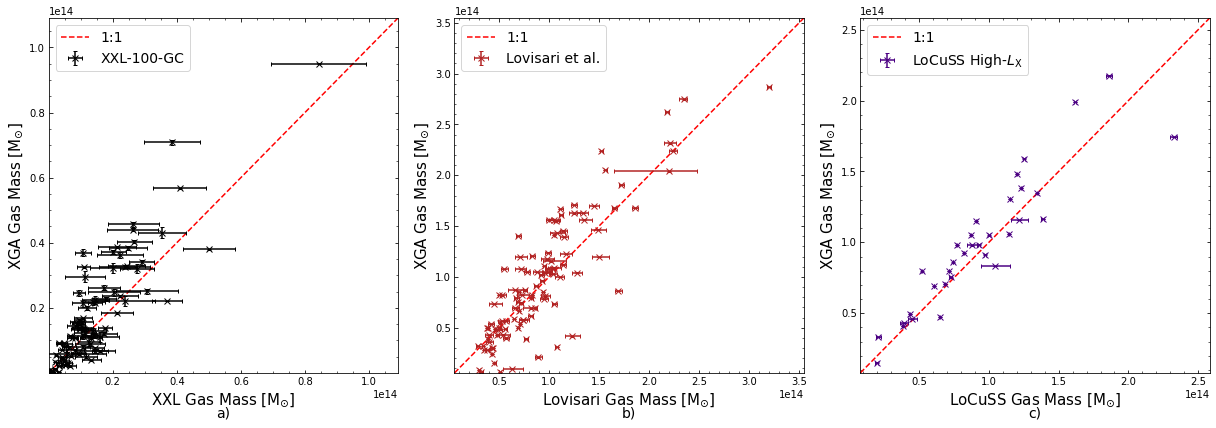

In [28]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_beta_king_13_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_beta_king_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_beta_king_1.3r500_gm_comp.pdf")
plt.show()

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [21]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [22]:
xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_dblbeta_13_dp = inv_abel_fitted_model(lovisari_srcs, 'double_beta', 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/97 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-94's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/97 [00:21<34:06, 21.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 607.55635146 1016.8370778  1143.51632437  521.22636413  897.17818658
 1018.98349298]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/97 [00:44<35:56, 22.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 291.13058045  747.84829886 1123.68095306  254.50138664  485.25429648
 1029.36459333]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   3%|▏       | 3/97 [01:07<35:14, 22.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 373.86726113  609.55934694 1941.61087103  265.30328495  259.90175176
 1719.46035497]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-106's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/97 [01:31<35:53, 23.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 347.1699138  1102.00355295 1604.92734509  624.60317747  723.07511677
 1374.33953846]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/97 [01:54<35:13, 22.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [288.78141551 761.34545157 942.94988203 319.68167426 580.8874813
 926.59571239]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 6/97 [02:16<34:23, 22.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 432.02604378 1547.53187195  890.87365072  486.57917491 1315.9950804
  659.62440522]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-93's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/97 [02:40<34:38, 23.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 422.37983949 1015.57355519 1553.33485597  587.3358263  1591.563704
 1561.71332417]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/97 [03:03<34:15, 23.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 584.5006173  1958.17180615 2155.70258642  218.72023242  312.72551529
 1773.47955264]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 9/97 [03:25<33:19, 22.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [387.91627474 581.44633559 651.88544763 419.16293046 699.02573903
 761.8464814 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/97 [03:47<32:59, 22.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 441.68535964 1067.30244949 1599.7674396   224.03534793  286.77798899
 1390.22495164]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-101's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/97 [04:10<32:20, 22.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [358.0421658  925.32700469 802.85926971 441.95679964 584.59769043
 725.33730913]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-109's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  12%|▊      | 12/97 [04:32<31:44, 22.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.8132915  590.11263317 642.97872886 295.27743648 598.61503227
 593.40932561]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  13%|▉      | 13/97 [04:57<32:41, 23.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 517.11631269 1739.03557999 2308.10870705  327.50070611  519.12025646
 2207.79606373]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [05:20<31:58, 23.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [492.72602448 980.59549042 980.38431712 417.94406953 833.90415732
 934.52959649]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 15/97 [05:42<31:14, 22.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 436.75292764  490.7441273  2274.99977452  656.18156551  733.1568183
  848.1858298 ]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏     | 16/97 [06:05<30:56, 22.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [268.01531341 639.72995127 992.43457846 248.59874579 393.4799171
 942.22222966]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/97 [06:31<31:49, 23.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 299.27825711  436.65710593 1416.73492346 1253.95301271  778.78844604
  768.68847951]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/97 [06:56<31:50, 24.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 324.31261151  578.2904554  1635.36489599 1034.58460695 1158.8820462
 1029.65344104]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▎     | 19/97 [07:20<31:17, 24.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [291.7713165  528.82114748 545.41096087 359.53419482 432.33396887
 559.64873018]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/97 [07:42<30:12, 23.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 604.51906525 1028.68258786 1305.85570363  732.58181699  908.36441167
 1347.81738154]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/97 [08:05<29:38, 23.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 337.53071889  398.62124694 1983.52485495  287.21864445  355.78672666
 1718.97841712]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.17669706 775.19448029 837.76259882 466.89932621 464.44267764
 540.64946394]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/97 [08:34<31:16, 25.01s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/97 [08:58<30:29, 24.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 388.39999537  611.30545798 1013.53941121  929.95906933  980.52044923
  844.62675775]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-56's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  25%|█▋     | 24/97 [09:22<29:54, 24.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 975.90111999 1090.76041245 1974.94504547  220.89103759  317.96938669
 1877.33143827]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [207.36158812 262.04110249 572.15587111 168.52779874 165.37389856
 155.79938159]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/97 [09:50<30:33, 25.46s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/97 [10:12<28:59, 24.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 474.10198584  860.91437209 1047.18901132  430.68911004  745.5231654
  651.2882545 ]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/97 [10:38<29:06, 24.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 698.9473945   806.96588781 2086.28491736 1514.500609   1881.10461459
 2055.82901475]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/97 [11:02<28:15, 24.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 878.13837354 1256.07415198 1828.55331923 1099.87021254 1303.5137386
 1776.1003797 ]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/97 [11:25<27:27, 24.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1185.93687356 1384.33351818 1678.71402239 1631.06930192 1746.68929154
 2079.23336901]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [154.33941534 239.08132979 428.28733016 189.47637028 222.11957811
 184.08994196]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 30/97 [11:53<28:14, 25.28s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-1's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 31/97 [12:17<27:33, 25.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 340.59920051  761.22860568 1677.0337843  1202.2485175  1179.63965322
 1068.39468718]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1469.14103032 1465.99367544 1467.51776977  509.59435463  546.84260972
  726.93174889]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/97 [13:17<29:11, 27.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 620.99939667  523.30747257 1087.83574499  846.47265507  926.15835946
  735.45786385]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [412.88322038 426.37330956 244.32862165 313.96019966 456.28359859
 450.82994887]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 34/97 [13:49<30:06, 28.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1946.15015253 1045.72856265 2196.34894834 1066.69030454 1038.83950198
 2130.33475813]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-50's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 35/97 [14:14<28:31, 27.61s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-55's density

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 405.52640414  980.71033295 1453.99860373  838.17878524 1157.69147368
 1308.34258692]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [549.79055268 557.93934321 930.42123679 445.59908489 653.05309487
 718.01831063]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 37/97 [15:10<27:59, 27.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 501.30938843  905.55867198 1859.60017667  614.84728085  923.5113286
 1569.57585473]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 39/97 [15:59<25:19, 26.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 499.64321923 1988.26888896 1537.27122967 1622.18214133 1783.97872804
 1879.52688615]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▉    | 40/97 [16:23<24:11, 25.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 276.19717475 1061.2002277  1364.98980218  233.54771481  349.58225823
  975.71823171]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 41/97 [16:47<23:24, 25.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 524.4921875  1746.4651058  1172.25381959 1229.99444452 1449.72378921
 1786.74759215]


Fitting data, inverse Abel transforming, and measuring densities:  43%|███    | 42/97 [17:12<23:01, 25.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 824.83780234 1398.40515217 1726.5311494  1174.13389048 1469.2659216
 1731.15601159]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 43/97 [17:37<22:30, 25.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 786.98983629 1054.58941836 1429.37477239  291.09267334  440.76209822
 1310.50240692]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [17:59<21:20, 24.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 476.25899695  703.86222197 1272.735712    806.09195912 1060.51851345
 1273.10006428]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 45/97 [18:21<20:23, 23.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [260.89288752 431.37800165 634.89359403 240.00026872 455.94732306
 571.55093787]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-104's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 46/97 [18:45<20:10, 23.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 863.46941687 1744.60868893 2043.93917577  238.39791853  311.99671222
 1935.65489778]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▍   | 47/97 [19:08<19:29, 23.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 381.85835941 1620.50547133 1376.20076138  387.97928186 1573.94801211
 1356.08622783]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 165.17264922  547.76062991 1194.19019821 1172.61405203 1343.76249871
  267.89508968]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 49/97 [20:04<20:48, 26.01s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-105's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  52%|███▌   | 50/97 [20:28<19:42, 25.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [323.66633211 521.95732601 501.3494813  359.87269185 423.42984561
 451.56148143]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 51/97 [20:54<19:31, 25.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [197.13219742 343.09597553 498.00490725 429.28275846 497.56599643
 726.78831647]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 970.34086619 1833.94827599 1218.74559457 1277.78402806 1416.09163083
 1615.29114744]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/97 [21:18<18:44, 24.98s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/97 [21:41<18:00, 24.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 329.89768609  694.5097346  1009.96526907  427.14202063  707.68456004
  858.50766659]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/97 [22:06<17:40, 24.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [197.87708785 547.69241097 322.79096169 249.88848121 260.05080696
 336.90736378]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-525's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 55/97 [22:30<17:09, 24.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 392.86530685  560.18027225 1307.53782807 1054.38851417 1167.11121893
  987.81918925]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/97 [22:53<16:22, 23.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.37351963 793.92105995 538.11963177 363.29741495 516.96034203
 711.07070443]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 57/97 [23:15<15:39, 23.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 573.32945521  611.42663225 1148.63454145  255.57730931  380.6316456
 1095.48395484]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-526's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 58/97 [23:38<15:10, 23.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1110.04284955 1434.75833533 1611.19675998  290.01118861  301.9747445
 1486.68348392]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [240.49998316 307.31139668 611.06745003 160.75102578 152.42851226
 147.09974484]


Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [24:31<15:07, 24.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 346.88366602 1042.19445642 1393.71460453  366.34920495  790.15296333
 1343.02939762]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  63%|████▍  | 61/97 [24:53<14:10, 23.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 522.75087129 1432.11566012 1059.61826012  477.04716751  735.31816361
  851.95184585]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 62/97 [25:14<13:26, 23.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 411.0927215   836.15595581 1052.50407742  226.39878758  439.56234712
  968.32689889]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-517's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  65%|████▌  | 63/97 [25:36<12:50, 22.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [221.06289633 427.51899573 330.43674942 285.26678066 368.22983917
 388.88885881]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-523's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 64/97 [25:58<12:18, 22.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.01311763 620.15068916 573.26480259 465.35675662 729.39159831
 644.68314991]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 65/97 [26:20<11:57, 22.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 397.6226272   790.44921205 1280.43248401  670.98392397  597.30354329
  605.70388821]


Fitting data, inverse Abel transforming, and measuring densities:  68%|████▊  | 66/97 [26:42<11:30, 22.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [376.20937536 686.86866359 625.07679314 524.12677241 981.28118802
 783.02355423]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 67/97 [27:08<11:43, 23.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 258.54880299  432.50419066 1772.77742785 1467.17355804 1211.14036909
  175.83400001]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 68/97 [27:36<11:59, 24.80s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-547's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 69/97 [28:00<11:26, 24.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [283.97912842 471.22859397 335.74615141 392.5229065  687.23734622
 506.64264097]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-535's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 70/97 [28:24<10:56, 24.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1052.02323769 1526.77191968 1846.26360847 1230.14465335 1527.10184028
 1812.95428039]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-536's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 71/97 [28:46<10:17, 23.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [397.12987663 885.56379576 961.48378805 416.58347832 765.85997438
 627.19043101]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 72/97 [29:10<09:49, 23.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 428.09372635 1204.15723473 1671.61079525  312.48607991  571.18439369
 1624.54802584]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 941.56096012 1068.02597075 1234.36819335  434.9826374   655.96921136
 1204.03161759]


Fitting data, inverse Abel transforming, and measuring densities:  75%|█████▎ | 73/97 [29:36<09:46, 24.44s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-521's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 74/97 [29:59<09:08, 23.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 422.91408524  583.07631788 1299.81754618  177.87439368  322.65188551
 1206.46919061]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 75/97 [30:32<09:46, 26.64s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 76/97 [30:54<08:52, 25.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 488.62462182  988.3036145  1429.51153224  254.51127176  373.18220594
 1282.61718771]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 77/97 [31:16<08:08, 24.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [454.17088537 839.84692675 871.97624539 256.16297698 351.55230104
 855.413389  ]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▋ | 78/97 [31:40<07:40, 24.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 441.49600523  709.76988378 1629.50445812  218.31144759  321.57421316
 1357.53604084]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [221.32077125 228.59977528 499.16498387 184.66261583 180.88403673
 145.97559121]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 79/97 [32:07<07:29, 24.99s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 80/97 [32:29<06:50, 24.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [339.86344033 613.96809217 685.34476109 445.28931871 679.72806615
 481.45091222]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▊ | 81/97 [32:53<06:24, 24.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [189.69035829 320.250709   578.20729939 477.16448641 343.05000486
 152.12246417]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/97 [33:16<05:55, 23.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [448.90234361 830.52152349 423.0534405  353.67967655 746.58872485
 511.30055177]


Fitting data, inverse Abel transforming, and measuring densities:  86%|█████▉ | 83/97 [33:45<05:53, 25.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [514.29398519 376.46805751 463.32246488 490.33820391 494.33123812
 516.84111471]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  87%|██████ | 84/97 [34:05<05:10, 23.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [372.27353308 794.47938982 836.4737806  276.41544721 542.52061374
 412.75025203]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-549's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 85/97 [34:27<04:39, 23.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 396.55178985  962.36278887 1470.0099896   688.41690736 1223.58461121
 1427.70033554]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 86/97 [34:49<04:10, 22.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.66726051 696.3541861  754.32399581 241.30098518 288.58521601
 713.1078387 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 87/97 [35:11<03:46, 22.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 309.03282906  635.48485437 1083.35317133  251.47090613  425.1596438
 1007.95413662]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 88/97 [35:33<03:21, 22.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 239.66149468  314.38220075 1319.65489025  247.51681527  405.90610576
 1029.13057116]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 89/97 [35:55<02:59, 22.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 315.71568064 1097.28139937 1554.56009966  328.9348757   845.15847239
 1359.42253439]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 90/97 [36:21<02:42, 23.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [172.59656221 216.85497341 523.38622519 456.50972601 254.45728948
 196.06481578]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [605.29928264 709.97708457 753.33285255 731.43565301 776.08696188
 964.85920338]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 91/97 [36:46<02:23, 23.97s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 92/97 [37:09<01:58, 23.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 761.46637555  288.64807478 2043.33402224  243.09437076  267.91915929
 1934.48783335]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-540's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 93/97 [37:32<01:33, 23.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 439.71000521 1436.96689239 1618.19198111  509.15225115  841.77723398
 1503.97794525]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 94/97 [37:55<01:09, 23.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 305.75813948 1002.02609242 1217.68007341  295.60163593  868.74631441
  904.19786974]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 95/97 [38:16<00:45, 22.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 430.07771781 1866.72968932 1260.68723491  507.50810388 1549.48257566
 1595.69393224]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-510's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 96/97 [38:38<00:22, 22.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [325.99889761 515.02552063 786.3909016  290.15250243 541.92076976
 790.42882726]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 97/97 [39:02<00:00, 24.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 742.70559767 1198.17334229 1110.15154007  631.17675674  567.79210145
  908.85321628]



/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|               | 0/119 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1873.825107    501.68627735 2180.41340812 1381.77921894  774.71560967
 2174.87216941]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G000.44-41.83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|       | 1/119 [00:24<48:32, 24.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2140.00187946  716.59748169 2136.17782642 1036.97751715  532.49580565
 2135.83917657]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G002.74-56.18's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|       | 2/119 [00:51<50:20, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1353.91952686  722.68183883 1663.08770845  286.46211433 1486.67977953
 1581.76827148]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▏      | 3/119 [01:21<53:30, 27.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.89796481 472.59041377 571.59036009 229.5472622  276.1609391
 283.13883263]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▏      | 4/119 [01:51<54:40, 28.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1362.86630124 1420.02515688 1801.48158911 1892.52398636 1878.77227297
 1772.22034023]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎      | 5/119 [02:21<55:44, 29.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1482.67388984  813.97237178 2119.51197603 2387.19674263 2319.43100895
 1810.06674479]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▎      | 6/119 [02:50<54:42, 29.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 728.9692016  1301.42787842 1111.59838084 1350.70526175 1312.14066681
 1198.41683352]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍      | 7/119 [03:16<52:21, 28.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [583.42848945 293.65876401 618.86458261  49.08831369 233.77027197
 537.52856198]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▍      | 8/119 [03:43<51:35, 27.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1965.97848567  544.65858666 2070.59907306 1390.514927    715.06214743
 2074.48247593]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌      | 9/119 [04:09<49:49, 27.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 805.75800146 1065.77153488 2015.19559496 1659.84187242 1661.74076217
 2022.02283254]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▌     | 11/119 [05:03<48:42, 27.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [243.36381733 657.15091536 664.2729711  808.40705419 784.54206651
 686.77366484]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2252.56360652 1316.93138213 2576.21854832 2572.31444114 2566.63045428
 1268.98448501]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▌     | 12/119 [05:33<50:04, 28.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1653.93429569  326.08931712 2098.87854364 1909.61733467  988.07567003
 2052.49367266]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G049.33+44.38's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  11%|▋     | 13/119 [06:05<51:18, 29.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1793.9949589   909.09875226 1784.42399734  964.96611802  811.18685118
 1782.22006223]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▋     | 14/119 [06:33<50:16, 28.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1250.236312    874.71473043 1850.55408552 1020.65362692  660.07149643
 1809.15839439]


Fitting data, inverse Abel transforming, and measuring densities:  13%|▊     | 15/119 [06:59<48:47, 28.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1969.9802688  1461.05633438 2478.77817749 2504.98580014 2489.54824429
 2147.79732001]


Fitting data, inverse Abel transforming, and measuring densities:  13%|▊     | 16/119 [07:27<48:11, 28.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1437.76288007  725.62043592 1998.97099368 1319.57821896 1349.88323948
 1999.03311577]


Fitting data, inverse Abel transforming, and measuring densities:  14%|▊     | 17/119 [07:53<46:36, 27.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 239.99743214  527.88058334 1003.39643317  174.45763868  173.06875234
  164.43340879]


Fitting data, inverse Abel transforming, and measuring densities:  16%|▉     | 19/119 [08:51<45:54, 27.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [997.37802523 999.33945774 746.74415858 231.36426929 254.9106713
 735.13102443]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█     | 20/119 [09:18<45:13, 27.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [190.9564058  157.43271697 917.3985009  179.16403919 619.74340216
 719.91611188]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█     | 21/119 [09:54<48:54, 29.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 964.36670183  862.8223629  1105.35941913  446.37949595  468.02628921
 1081.09052787]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▏    | 24/119 [11:23<47:19, 29.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1228.28904631 1364.22995146 1885.74802139 2270.57020471 2269.57516603
 2040.31214462]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▎    | 25/119 [11:51<45:53, 29.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1505.2959704   352.28404192 1955.767394   1098.65560812  918.34874715
 1945.02805204]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▎    | 27/119 [12:51<45:36, 29.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1085.66496547  745.32825615  849.59639017  188.91320845  273.01254412
  749.69079133]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▍    | 28/119 [13:18<43:53, 28.94s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:965: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  "rather than a model name.")
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:779: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  y_errs = self.values_err.copy().value
/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G080.99-50.90

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1880.22194131 1053.98398506 2166.96416336 1329.1561922   784.96544229
 2162.79726311]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G085.99+26.71's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  26%|█▌    | 31/119 [14:30<37:37, 25.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1829.49408779  656.88787154 2002.94062308 1408.53681368 1081.03552473
 2002.35567191]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 670.22792177  486.04403506 1629.98656406 1873.40879319 1870.74462312
 1483.86024203]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▌    | 32/119 [14:58<38:11, 26.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 523.05145246  924.17976588 1735.41875104 2316.03474495 2269.6917326
 1755.4402131 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G092.73+73.46's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  28%|█▋    | 33/119 [15:25<38:06, 26.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1049.62637975  900.76773022  600.28349966 1582.31516226 1585.94728241
 1485.14230938]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G093.91+34.90's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  29%|█▋    | 34/119 [16:00<40:56, 28.90s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G096.87+24.21

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 366.66300142  359.48768803 1019.14435665  168.70802031  247.15847827
  730.36302119]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1140.63682665  760.44928223 1923.10318774 1944.61797774 2024.41478796
 1948.08937656]


Fitting data, inverse Abel transforming, and measuring densities:  30%|█▊    | 36/119 [16:52<38:21, 27.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 806.1292084  1560.41628017 1189.54515487  914.6892374  1558.13571555
 1125.84329558]


Fitting data, inverse Abel transforming, and measuring densities:  31%|█▊    | 37/119 [17:20<38:12, 27.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1739.05672505  702.31363899 2000.1009269  1156.0983755   642.34904036
 1999.53849698]


Fitting data, inverse Abel transforming, and measuring densities:  32%|█▉    | 38/119 [17:43<35:35, 26.36s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G107.11+65.31's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  33%|█▉    | 39/119 [18:06<33:57, 25.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1532.14842646  644.99690537 1486.05542795  868.08846328  649.21549258
 1482.48346284]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G113.82+44.35's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██    | 40/119 [18:30<32:39, 24.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1018.2732327  1623.59999736 1030.53302821  991.13736906  851.56639318
 1374.78371802]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [307.86486687 434.4792333  291.3545505  311.33945442 316.5445587
 295.23376332]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██    | 41/119 [18:56<32:56, 25.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 666.07286057  939.56289858 1930.67153691  900.73570079 1377.73525982
 1941.50805106]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██    | 42/119 [19:21<32:17, 25.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1561.57570348 1362.77774034 1796.41468161  980.36586201 1008.17379385
 1644.81430368]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▏   | 43/119 [19:44<30:58, 24.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1502.28455399  998.25338566 1769.39781699  787.97325238  578.99882857
 1652.66762869]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▎   | 45/119 [20:35<31:00, 25.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 374.69296033  402.4802596  1725.01935641 1508.36985389 1489.38274342
 1475.86395132]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [182.41972148 459.77401275 289.66934149 139.05734403 154.55052709
 185.13912266]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▎   | 47/119 [21:32<32:11, 26.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1072.95215876  439.14097449 2323.17375661 2170.5018035  2121.32559519
 2305.87435397]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▍   | 48/119 [22:02<32:50, 27.75s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G171.94-40.65's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▍   | 49/119 [22:26<31:14, 26.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2004.16543322  261.7804628  2096.21872428 1169.38029441  763.0491645
 2094.84964806]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▌   | 50/119 [22:54<30:55, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [414.53267772 444.12249912 622.37646712 938.672534   877.53621582
 524.94952273]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 636.52608827 1413.91786402 2285.73093034 2150.50984703 2111.60619209
 2009.49459263]


Fitting data, inverse Abel transforming, and measuring densities:  43%|██▌   | 51/119 [23:19<29:56, 26.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1595.66618077 1598.56037639 2057.59330576 1157.70058212  989.83062706
 1994.62678167]


Fitting data, inverse Abel transforming, and measuring densities:  45%|██▋   | 53/119 [24:06<27:20, 24.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1362.66941756  879.5864143  1162.19855095  435.93382254  434.93169722
 1147.54659094]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [625.75290797 464.11548713 800.59863918  49.47017441 263.83154867
 735.00202357]


Fitting data, inverse Abel transforming, and measuring densities:  50%|██▉   | 59/119 [26:41<26:10, 26.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1045.36944708  957.79785587 2188.29850398 1676.85808776 1871.59591502
 2163.44888848]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 378.80640304 1260.10296733 1588.14332008  533.39710451 1332.40910818
  913.32285312]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G228.49+53.12's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  50%|███   | 60/119 [27:05<25:15, 25.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1763.94132778 1229.30826643 1888.26122514 1164.51147792  715.38670209
 1892.37534537]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███   | 61/119 [27:30<24:32, 25.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1106.86480589  878.0014345  1224.53530847  560.79659734  415.82733167
 1073.05470436]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▏  | 62/119 [27:57<24:32, 25.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 426.53759246  265.07833233 1559.46123129 1549.99457262 1594.34270247
 1458.86549375]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▏  | 63/119 [28:24<24:26, 26.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1998.97623609  141.77022958 2382.53650872 2405.18216738 2408.00496907
 2347.48873897]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▏  | 64/119 [28:53<24:52, 27.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 181.94686946 2104.76746766 2489.24704321 2539.51332709 2527.93530764
 2429.95916929]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G241.97+14.85's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  55%|███▎  | 65/119 [29:23<25:02, 27.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1449.37693012 1138.33105947 1680.38968382 1073.81519131  756.52739848
 1677.91645162]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▎  | 66/119 [29:46<23:24, 26.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 762.81176662  734.30809196 1750.38034661  896.92119726 1000.14544992
 1743.14664703]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G244.69+32.49's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  56%|███▍  | 67/119 [30:13<23:07, 26.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1771.37892564  959.78230448 1938.04768093 1113.31747683  702.38753787
 1947.86043532]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▍  | 68/119 [30:38<22:08, 26.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1301.77936282 1061.25351443 2005.15517876  593.54371711  945.68614904
 1974.32979737]


Fitting data, inverse Abel transforming, and measuring densities:  58%|███▍  | 69/119 [31:02<21:22, 25.64s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G250.90-36.25's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|███▌  | 70/119 [31:28<20:50, 25.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1600.88233986  227.08610275 1922.98709655  941.40912412  560.19689057
 1908.01538576]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [737.55525627 428.09973148 701.69540431  40.26944512 184.90649722
 589.83768893]


Fitting data, inverse Abel transforming, and measuring densities:  60%|███▌  | 71/119 [31:58<21:36, 27.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1139.73438447  348.1364098  2000.8807708  1683.59157435 1196.21347362
 1944.76445491]


Fitting data, inverse Abel transforming, and measuring densities:  61%|███▋  | 72/119 [32:26<21:25, 27.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 295.5489144   602.91481624 1019.79909721  282.5730933   243.10404569
  250.39752008]


Fitting data, inverse Abel transforming, and measuring densities:  61%|███▋  | 73/119 [32:52<20:40, 26.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 924.91701902 1589.68529727  986.19274033  658.83415694  754.82406366
 1328.29271246]


Fitting data, inverse Abel transforming, and measuring densities:  62%|███▋  | 74/119 [33:17<19:37, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1442.9841215  1265.15666191 1580.21376621  988.57810932  804.64987535
 1518.46370025]


Fitting data, inverse Abel transforming, and measuring densities:  63%|███▊  | 75/119 [33:40<18:30, 25.23s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G262.25-35.36's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|███▊  | 76/119 [34:06<18:18, 25.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1500.93662883  948.38865665 1572.61997198 2230.17487883 2243.80250097
 1724.31223953]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G262.71-40.91's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  65%|███▉  | 77/119 [34:30<17:27, 24.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 272.78862192  258.51725449 1634.34454981  195.16476946  295.39951174
 1277.18725941]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1114.84331199  519.85832815  750.7487962   210.57817818  197.2189641
  663.82516471]


Fitting data, inverse Abel transforming, and measuring densities:  66%|███▉  | 78/119 [34:55<17:06, 25.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2080.22764202 1121.87751286 2468.9087634  2413.23086784 2260.3967279
 2288.99398144]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████  | 80/119 [35:52<17:22, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 450.35761623 1010.44131312 1044.36653609  609.82688214  537.73954062
  952.24432158]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▏ | 82/119 [36:48<16:50, 27.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1647.64052829  587.38239958 2029.60548057 1357.43704216  853.00632315
 2033.3834109 ]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▏ | 84/119 [37:35<14:41, 25.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1823.01458753 1633.57578148 2208.10584726 1366.18772746 1115.64365994
 2202.99626478]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G278.60+39.17's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  71%|████▎ | 85/119 [37:58<13:57, 24.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1759.62288509 1384.78497105 1839.52614408 1176.89114375  767.78245054
 1836.75428868]


Fitting data, inverse Abel transforming, and measuring densities:  73%|████▍ | 87/119 [38:55<14:02, 26.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [460.3877308  675.86624388 831.8031513  624.29232843 686.3891457
 795.34497208]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G284.46+52.43's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  74%|████▍ | 88/119 [39:21<13:33, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 496.30786033  388.93835751 2212.73114283 1212.14153516 1736.88852646
 2202.4816034 ]


Fitting data, inverse Abel transforming, and measuring densities:  75%|████▍ | 89/119 [39:48<13:13, 26.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1585.57399975  178.88331235 2272.19477581 2293.76470171 2291.87432901
 2038.91714678]


Fitting data, inverse Abel transforming, and measuring densities:  76%|████▌ | 90/119 [40:11<12:19, 25.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1538.32395835  598.31583983 1795.6688867   862.20346607  787.29529026
 1772.96886023]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [410.73172285 947.36045989 556.79241464 679.94605024 759.39626751
 853.36583721]


Fitting data, inverse Abel transforming, and measuring densities:  76%|████▌ | 91/119 [40:40<12:18, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1443.42272939 1620.83593476 2195.0377029  2149.997577   2169.28465758
 2192.1547365 ]


Fitting data, inverse Abel transforming, and measuring densities:  77%|████▋ | 92/119 [41:06<11:52, 26.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 954.11143764  635.52673414 1384.57274996  690.59015803  396.90066047
 1367.77222368]


Fitting data, inverse Abel transforming, and measuring densities:  78%|████▋ | 93/119 [41:33<11:31, 26.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 939.77696211 1501.79085028 2229.34790419 2411.44322758 2401.92002602
 2220.92386846]


Fitting data, inverse Abel transforming, and measuring densities:  79%|████▋ | 94/119 [41:59<10:59, 26.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1006.92107459  368.98368467 1683.05598575  419.70104124  686.4666723
 1673.508955  ]


Fitting data, inverse Abel transforming, and measuring densities:  80%|████▊ | 95/119 [42:25<10:30, 26.28s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G304.67-31.66's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  81%|████▊ | 96/119 [42:49<09:48, 25.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 554.99511699 1553.66248941  615.69686808  428.39121572  795.7757272
 1228.53083931]


Fitting data, inverse Abel transforming, and measuring densities:  82%|████▉ | 97/119 [43:12<09:07, 24.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1654.57577965 1281.45239343 1788.77781241  831.27016958  654.60873021
 1782.27712404]


Fitting data, inverse Abel transforming, and measuring densities:  83%|████▉ | 99/119 [44:14<09:03, 27.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1663.39439511 1917.16353598 2062.34864359  850.77182576  854.25209873
 2055.54493003]


Fitting data, inverse Abel transforming, and measuring densities:  84%|████▏| 100/119 [44:47<09:13, 29.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [474.10650054 600.94993496 536.17734717 186.2845712  217.72787477
 268.27212893]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G313.87-17.10's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  85%|████▏| 101/119 [45:15<08:34, 28.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1298.84373927  425.35941723 1549.81093768  760.30522822  797.7931764
 1535.6967812 ]


Fitting data, inverse Abel transforming, and measuring densities:  86%|████▎| 102/119 [45:39<07:44, 27.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1404.99300801  423.93171211 2046.66205196 2131.59321663 1666.16584248
 2089.88595946]


Fitting data, inverse Abel transforming, and measuring densities:  87%|████▎| 103/119 [46:10<07:34, 28.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1805.14851965  642.97334075 2089.28186736 1263.23490303  775.35969761
 2089.94843148]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G324.49-44.97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  88%|████▍| 105/119 [47:09<06:49, 29.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1724.97817645  732.91519783 1988.34035249  789.72689941  756.10030656
 1979.34424943]


Fitting data, inverse Abel transforming, and measuring densities:  89%|████▍| 106/119 [47:34<06:02, 27.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [312.34604595 780.28221231 772.54635172 412.49828947 391.65059678
 572.81453764]


Fitting data, inverse Abel transforming, and measuring densities:  90%|████▍| 107/119 [47:59<05:25, 27.09s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G337.09-25.97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|████▌| 108/119 [48:20<04:37, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 409.58447637  389.82842761 1177.81654509  468.90889964  376.5865669
  811.58666807]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1085.79896658  534.97943043 1210.67745134  740.0949971   848.78535443
 1208.52086903]


Fitting data, inverse Abel transforming, and measuring densities:  92%|████▌| 109/119 [48:43<04:05, 24.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 684.02916958  802.07923767 1768.5015293  1924.77567935 1928.62814043
 1782.50657184]


Fitting data, inverse Abel transforming, and measuring densities:  93%|████▋| 111/119 [49:32<03:34, 26.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 934.34373118 2060.35380041 2478.85146273 2507.56514051 2487.38629609
 1165.18552684]



/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1393.39347608  534.22291845 1479.37025356 1430.97077157 1557.50449613
 1494.13189607]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/46 [00:27<20:23, 27.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [462.98627498 337.77876696 432.27133898 303.14713409 317.56400017
 387.46094875]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/46 [00:56<20:43, 28.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1384.59250082  891.48927629 1928.88313101 1691.97491947 1845.06962169
 1957.14353692]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:44<17:50, 25.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 776.5883111  1317.43610069 1181.46617495 1180.99529461 1270.9629241
 1515.36183508]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/46 [02:36<17:08, 25.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [178.73429446 411.84123972 428.99412995 381.2174511  408.85465056
 437.33884113]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 7/46 [03:06<17:42, 27.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 442.13294159  207.92039042 1930.7259505  1873.19400668 1930.20292448
 1826.93499271]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▍      | 8/46 [03:35<17:39, 27.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.75212133 396.82236105 300.94835407 375.84350129 378.33394748
 367.42117747]


Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 10/46 [04:40<18:07, 30.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [240.66924533 865.64218828 734.90331555 217.79285891 191.25246761
 244.13822964]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 12/46 [05:39<16:57, 29.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1538.93498969  870.04831733 1946.90514042 1823.77438402 1877.87617192
 1804.7715139 ]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [06:06<15:58, 29.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 343.37255816 1226.22980768 1033.79608683 1007.19537243 1146.84257238
 1281.94417135]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [07:05<15:15, 29.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [568.27198429 558.29395059 429.51115827 430.51827676 478.03687978
 554.62662883]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [182.19128132 331.86842535 720.43518698 181.39551479 186.58454838
 180.35895275]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 16/46 [07:33<14:31, 29.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 647.91858491  527.9878085  1687.05653039 1225.48130979 1255.40017333
 1478.34612279]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 17/46 [08:04<14:15, 29.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 736.16865397  568.86108963 1302.98695916  725.14303136  613.05192349
 1305.97923832]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [10:38<12:33, 31.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1918.44870599  206.87055799 2464.1388509  2304.58851496 1231.21669465
 2451.03905638]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [11:30<10:23, 28.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1170.63315107  626.91322507 1325.71369359  956.16851277  710.38165113
 1323.25637399]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 872.13204795 1747.16209134 1795.42577066  663.75954347 1650.5014795
 1796.19358743]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 26/46 [12:35<10:16, 30.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1959.73387793  322.03041102 2044.24644801 1193.53479756  804.718924
 2044.37508109]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [12:59<09:11, 29.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 529.90809128  708.07382675 1120.72437819  985.08428547  741.54087854
  695.23726453]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▊  | 32/46 [15:41<07:34, 32.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 743.51803832  522.97705612 1619.25783133 1319.50723411 1454.98128254
 1606.26836714]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 34/46 [16:34<05:56, 29.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1122.36819717  813.41698952 1036.87765256  994.39680641 1039.83405657
 1061.87461357]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 36/46 [17:37<05:06, 30.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [223.28400579 386.29820513 498.64638232 541.29952676 571.46510537
 529.18657532]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [21:01<01:24, 28.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1219.4552391   955.04666965 1063.79244052  679.69173087  838.12087794
 1266.75100912]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [21:28<00:56, 28.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [546.68492981 419.99638965 550.96607704 377.42849627 475.2577473
 582.9153854 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1014.1746833  1330.60537632 1665.11018047 1366.70423177 1470.28371409
 1635.45849556]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [22:18<00:00, 26.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 523.16685951  921.70770149 1559.23584494 1489.28188861 1040.31590285
 1574.39662477]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [22:18<00:00, 29.09s/it]


In [23]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [24]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:   6%|██▏                                | 6/97 [00:34<08:36,  5.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 657.5590407  1552.13186098  923.10075479 1271.24678029  559.3867795
 1079.3332953 ]


Fitting density model to XXL profiles:  16%|█████▌                            | 16/97 [01:10<05:45,  4.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 624.51517017 1641.39945385  349.55326057  936.28142331  297.3982395
  489.15579266]


Fitting density model to XXL profiles:  18%|█████▉                            | 17/97 [01:52<10:17,  7.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [252.57316046 360.98366002 844.55884757 207.62225975 169.22554112
 479.36423007]


Fitting density model to XXL profiles:  19%|██████▎                           | 18/97 [02:32<15:00, 11.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 245.87584668  343.07091911 1281.38148128  227.89206583  150.89152382
  534.38005109]


Fitting density model to XXL profiles:  20%|██████▋                           | 19/97 [03:08<19:26, 14.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 559.69778787 1386.18696816  614.58291117 1027.64185548  398.55266076
  745.38487563]


Fitting density model to XXL profiles:  23%|███████▋                          | 22/97 [04:02<20:01, 16.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 860.74671265 2011.14007712 1760.23021234 1677.72621611 1404.56069179
 1949.07607358]


Fitting density model to XXL profiles:  26%|████████▊                         | 25/97 [04:41<17:55, 14.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 834.10240064 1976.08774466 1183.88777519 1583.32436236  749.05028935
 1508.3713091 ]


Fitting density model to XXL profiles:  28%|█████████▍                        | 27/97 [05:18<18:35, 15.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 686.29405207  932.11279158 1271.45739913 1113.1279616  1053.32155301
 1305.25840495]


Fitting density model to XXL profiles:  29%|█████████▊                        | 28/97 [05:55<21:54, 19.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1153.98038037 1266.99855591 1605.6465141   831.58007205  357.72598848
 1450.80173039]


Fitting density model to XXL profiles:  30%|██████████▏                       | 29/97 [06:29<24:39, 21.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2106.21250296 2451.29534318 1844.42539    1774.00183934  785.11632793
 2408.22740713]


Fitting density model to XXL profiles:  31%|██████████▌                       | 30/97 [07:11<28:53, 25.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 616.67438022 1407.39653037  765.52311984 1223.98465094  656.5610151
 1087.74469605]


Fitting density model to XXL profiles:  35%|███████████▉                      | 34/97 [08:37<25:55, 24.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [149.52888162 440.47476557 630.20798002 135.40922054 108.57744615
 560.39590115]


Fitting density model to XXL profiles:  38%|████████████▉                     | 37/97 [09:21<20:23, 20.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 531.33518475 1705.66968223  723.66446105  585.16430389  697.57516229
 1140.77047153]


Fitting density model to XXL profiles:  40%|█████████████▋                    | 39/97 [09:59<19:11, 19.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 589.07861286 1290.51025467  820.0406043   871.76923815  512.53964265
 1189.93365823]


Fitting density model to XXL profiles:  42%|██████████████▎                   | 41/97 [10:34<17:54, 19.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2620.35982208 3009.63503302 2706.83318733 1530.77439284 1302.67217166
 3134.85403836]


Fitting density model to XXL profiles:  43%|██████████████▋                   | 42/97 [11:13<20:45, 22.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1735.18757683 1964.8938964  2899.34196937 1412.51288897  460.4510351
 2207.68446446]


Fitting density model to XXL profiles:  44%|███████████████                   | 43/97 [11:49<22:51, 25.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [551.67152609 760.91117753 432.16255451 827.15831171 377.19516051
 545.92184248]


Fitting density model to XXL profiles:  45%|███████████████▍                  | 44/97 [12:21<23:40, 26.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 626.46612003 1991.92287828  767.33654213  707.90265415  629.53197816
 1452.1450481 ]


Fitting density model to XXL profiles:  49%|████████████████▊                 | 48/97 [13:03<14:24, 17.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [108.95605016 159.12156322 975.45332383 119.38144937 125.01244128
 270.30200226]


Fitting density model to XXL profiles:  51%|█████████████████▏                | 49/97 [13:54<18:35, 23.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1336.44159975 1950.34786871 1269.22935498 1933.37716903 1170.78589405
 1589.04936842]


Fitting density model to XXL profiles:  53%|█████████████████▉                | 51/97 [14:31<16:39, 21.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3061.56119457 3266.56900544 3415.22795623 2440.48985502 2347.9926702
 3363.3678107 ]


Fitting density model to XXL profiles:  54%|██████████████████▏               | 52/97 [15:09<18:35, 24.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1376.59273322 1747.59882836 1060.20527047 1174.00438105  832.06455446
 1521.4348823 ]


Fitting density model to XXL profiles:  61%|████████████████████▋             | 59/97 [16:31<09:32, 15.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 820.2919414  1590.38180039  800.28826332 1392.64734382  578.6979006
 1213.08476755]


Fitting density model to XXL profiles:  62%|█████████████████████             | 60/97 [17:07<11:02, 17.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 505.05595121  698.8888771  1411.18630394  318.54853875  234.19643192
  924.92339177]


Fitting density model to XXL profiles:  68%|███████████████████████▏          | 66/97 [17:41<05:50, 11.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 376.62724183 1206.42749602  550.13133227 1067.82428662  427.7608986
  626.300399  ]


Fitting density model to XXL profiles:  69%|███████████████████████▍          | 67/97 [18:21<07:17, 14.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 294.48312286 1034.37484926 1901.72591735  330.18127017  217.1617517
 1110.79799487]


Fitting density model to XXL profiles:  70%|███████████████████████▊          | 68/97 [19:02<08:49, 18.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 558.26986913 1266.58682512  853.67910725 1141.54674928  797.98524553
 1133.02633268]


Fitting density model to XXL profiles:  74%|█████████████████████████▏        | 72/97 [19:37<05:51, 14.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [679.36917885 370.58425673 205.30374058 364.3394674  186.19037671
 215.75469726]


Fitting density model to XXL profiles:  75%|█████████████████████████▌        | 73/97 [20:21<07:13, 18.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [695.82912598 611.3859884  300.24377795 511.39835521 244.55343858
 315.94011049]


Fitting density model to XXL profiles:  80%|███████████████████████████▎      | 78/97 [22:21<06:57, 21.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1285.49847038 2013.70638745  513.85885934 1521.22011369  543.52517766
  579.65003656]


Fitting density model to XXL profiles:  81%|███████████████████████████▋      | 79/97 [23:00<07:35, 25.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1027.36517786 1897.58575772  676.17518085 2089.8509155   804.19460274
 1112.47707592]


Fitting density model to XXL profiles:  85%|████████████████████████████▋     | 82/97 [23:36<04:49, 19.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [522.99904456 953.16917879 515.16004379 812.23404691 357.21386776
 614.44711761]


Fitting density model to XXL profiles:  86%|█████████████████████████████     | 83/97 [24:18<05:27, 23.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [191.715773   335.54048199 613.96012883 139.7777836  107.86736023
 372.57757031]


Fitting density model to XXL profiles:  93%|███████████████████████████████▌  | 90/97 [24:54<01:21, 11.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2901.17312724 3216.20943355 3346.807051   2046.91985042 2216.59883215
 3483.41001637]


Fitting density model to XXL profiles:  94%|███████████████████████████████▉  | 91/97 [25:35<01:30, 15.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2590.80022123 2803.53119207 3199.76238005 2144.75708487  782.48342862
 3107.09192157]


Fitting density model to XXL profiles:  97%|████████████████████████████████▉ | 94/97 [26:11<00:41, 13.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 474.992262   1447.21374759  447.75925039  920.05214734  324.59782686
  529.65996475]


Fitting density model to XXL profiles:  98%|█████████████████████████████████▎| 95/97 [26:45<00:33, 16.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 841.92871502 1497.5177845   888.64415109 1074.41555087  508.31084729
 1185.26788386]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 97/97 [27:23<00:00, 16.94s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 585.77395904 1519.6835938   811.17533308  993.77506376  437.05939234
 1220.15183087]


Fitting density model to Lovisari profiles:   3%|▋                            | 3/119 [00:53<34:34, 17.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1225.04231117 1210.54315375  414.10282904 1338.922217   1113.9951369
  490.71184714]


Fitting density model to Lovisari profiles:   3%|▉                            | 4/119 [01:45<55:17, 28.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1528.9165929  1590.92204118  760.61015998 1312.51317389 1288.0207314
  878.10957757]


Fitting density model to Lovisari profiles:   7%|█▊                         | 8/119 [05:00<1:21:18, 43.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1460.49478627 1489.35354871  818.39931267 1323.42844798 1435.27990513
  500.88232271]


Fitting density model to Lovisari profiles:   8%|██                         | 9/119 [05:47<1:22:22, 44.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1173.77084652 1316.97782047  866.18473822 1265.52871137  885.83172833
  933.68473285]


Fitting density model to Lovisari profiles:   8%|██▏                       | 10/119 [06:32<1:21:07, 44.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 558.92918522  581.26374395 2441.15904154  732.18575644  449.17256071
 1408.9856124 ]


Fitting density model to Lovisari profiles:  13%|███▊                        | 16/119 [08:57<49:28, 28.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1691.4146987  1685.55936908  569.53187656 1316.64299561 1228.03506845
  646.76758531]


Fitting density model to Lovisari profiles:  14%|████                        | 17/119 [09:49<57:04, 33.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1497.4587565  1508.00072848  681.68958335 1010.84187547 1434.45444417
  769.49796243]


Fitting density model to Lovisari profiles:  16%|████▏                     | 19/119 [11:25<1:06:07, 39.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1502.57647974 1465.90604975  691.68368046 1336.96505232 1265.2271569
  790.37633895]


Fitting density model to Lovisari profiles:  17%|████▎                     | 20/119 [12:16<1:10:06, 42.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1682.2696321  1292.40713044  509.35037941 1653.60280857  579.65851226
  734.79795854]


Fitting density model to Lovisari profiles:  18%|████▌                     | 21/119 [12:55<1:07:43, 41.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2668.50247026 2662.38811235  594.1623156  1735.43619471 2748.11793114
  632.66439643]


Fitting density model to Lovisari profiles:  19%|█████                     | 23/119 [14:52<1:21:47, 51.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [476.86580354 817.05841156 530.30495226 718.33951634 464.29342732
 726.51314881]


Fitting density model to Lovisari profiles:  20%|█████▏                    | 24/119 [15:43<1:20:54, 51.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1604.37408872 1570.34601893  702.85633827 1096.65728474 1399.74323625
  807.8795463 ]


Fitting density model to Lovisari profiles:  21%|█████▍                    | 25/119 [16:42<1:23:38, 53.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [657.96392689 766.21435592 550.56324702 539.78748573 716.0969864
 654.56155934]


Fitting density model to Lovisari profiles:  22%|█████▋                    | 26/119 [17:29<1:19:31, 51.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [605.95974351 642.91629081 362.8518139  639.2866843  618.59224593
 425.76502591]


Fitting density model to Lovisari profiles:  23%|█████▉                    | 27/119 [18:18<1:17:46, 50.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1593.74539396 1588.55980755  371.97795601 1157.12931004 1600.62900237
  543.10188342]


Fitting density model to Lovisari profiles:  24%|██████                    | 28/119 [19:10<1:17:45, 51.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1911.52621464 1951.46293212  602.58451242 1217.29990693 1918.43425262
  584.32183698]


Fitting density model to Lovisari profiles:  25%|██████▌                   | 30/119 [20:51<1:15:11, 50.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1804.95726076 1802.87968721  825.52557503 1369.68059521 1537.49069045
  890.70134536]


Fitting density model to Lovisari profiles:  29%|████████                    | 34/119 [21:39<37:14, 26.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1610.17562397 1585.68240505  582.84919876 1226.16458239 1629.24305958
 1066.33092771]


Fitting density model to Lovisari profiles:  33%|█████████▏                  | 39/119 [23:17<31:57, 23.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1325.29863015 1968.32223288 1858.87403016 2164.49191805 1052.12391971
 2064.33998461]


Fitting density model to Lovisari profiles:  34%|█████████▍                  | 40/119 [23:57<35:12, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1796.97857407 1884.66724059  852.16453494 1102.17105672 1670.75461416
  910.97163932]


Fitting density model to Lovisari profiles:  36%|██████████                  | 43/119 [24:42<27:33, 21.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 721.57607312  896.3427134   956.90432858 1194.66545825  733.05295793
 1073.04132778]


Fitting density model to Lovisari profiles:  37%|██████████▎                 | 44/119 [25:25<31:40, 25.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1288.33559264 1435.9974634   784.23577466 2055.74200368  967.2595896
 1370.90582697]


Fitting density model to Lovisari profiles:  38%|██████████▌                 | 45/119 [26:05<34:51, 28.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 906.61512524 1224.83962215  761.650879   1242.85820247  866.03458405
  938.3507479 ]


Fitting density model to Lovisari profiles:  39%|██████████▊                 | 46/119 [26:52<39:20, 32.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1228.98858394 1373.98900597  871.05624326 1223.09966526 1227.39915187
 1009.16348729]


Fitting density model to Lovisari profiles:  40%|███████████▎                | 48/119 [28:21<44:43, 37.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [793.41964494 837.9592715  384.09101244 559.98456926 243.84582577
 906.39805615]


Fitting density model to Lovisari profiles:  46%|████████████▉               | 55/119 [31:26<29:10, 27.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 360.50140966 1109.5339608   235.88267789  335.75921278  939.54312841
  233.10903663]


Fitting density model to Lovisari profiles:  47%|█████████████▏              | 56/119 [32:07<31:44, 30.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 857.68712827 1060.44513861  731.89853699 1166.4875323   887.1611846
  806.74541445]


Fitting density model to Lovisari profiles:  48%|█████████████▍              | 57/119 [32:48<33:37, 32.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1628.33091187 1735.09881737  582.78981343 1644.00149534 1824.95934509
  591.34940465]


Fitting density model to Lovisari profiles:  49%|█████████████▋              | 58/119 [33:32<35:56, 35.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2158.30622161 2164.66622586  686.31138185 1197.76141196 2192.93113025
  673.75712316]


Fitting density model to Lovisari profiles:  50%|█████████████▉              | 59/119 [34:14<37:06, 37.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1472.88373181 1372.56033467  639.79052431 1164.51998413 1017.11290564
  699.49368496]


Fitting density model to Lovisari profiles:  50%|██████████████              | 60/119 [34:53<36:58, 37.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1115.66298024 1452.81225296  987.19034592 1351.92448835 1065.5730971
 1137.26709688]


Fitting density model to Lovisari profiles:  51%|██████████████▎             | 61/119 [35:42<39:23, 40.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1423.84626644 2256.69750033 2061.3460827  2149.40604832  713.99453932
 2158.26404472]


Fitting density model to Lovisari profiles:  52%|██████████████▌             | 62/119 [36:30<40:52, 43.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1493.35358238 1510.95614216  842.11618363 1543.17949217 1487.35937916
  765.5696807 ]


Fitting density model to Lovisari profiles:  53%|██████████████▊             | 63/119 [37:11<39:27, 42.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 259.04876182  259.68457702 1599.79750049  250.17275819  147.64242234
  540.79677732]


Fitting density model to Lovisari profiles:  55%|███████████████▎            | 65/119 [37:55<29:42, 33.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1190.94370308 1259.14904727  777.28435412 1236.04363528 1130.45951732
  867.34153837]


Fitting density model to Lovisari profiles:  56%|███████████████▊            | 67/119 [38:42<25:31, 29.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2112.83712872 2113.40591872  942.28918816 1679.93748074 2106.31660658
 1154.90406274]


Fitting density model to Lovisari profiles:  58%|████████████████▏           | 69/119 [40:17<30:40, 36.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 95.61826281  98.25720159 637.09306457 104.19056677 123.79100715
  83.16426756]


Fitting density model to Lovisari profiles:  60%|████████████████▋           | 71/119 [40:58<24:08, 30.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1339.5365393  1353.39218004  766.43821875 1048.446885   1247.29898308
  840.47003308]


Fitting density model to Lovisari profiles:  61%|█████████████████▏          | 73/119 [41:42<20:47, 27.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1164.67530439 1093.79112692  741.55128611 1020.28534967  955.73818576
  734.64383159]


Fitting density model to Lovisari profiles:  62%|█████████████████▍          | 74/119 [42:23<22:36, 30.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1291.13797003 1092.4974146   612.9886503   934.0507254  1199.58465423
  728.56926221]


Fitting density model to Lovisari profiles:  64%|█████████████████▉          | 76/119 [43:17<20:44, 28.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1532.93203193 1511.82922322  741.04375916 1447.39976336 1354.18772889
  117.34727995]


Fitting density model to Lovisari profiles:  66%|██████████████████▎         | 78/119 [44:48<24:04, 35.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2079.97500081 2098.31745064  786.35436481  977.18856396 2065.79517395
  820.93610886]


Fitting density model to Lovisari profiles:  66%|██████████████████▌         | 79/119 [45:31<24:46, 37.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1007.74517524 1446.42065015  983.01930954 1433.44969037  722.4763298
 1143.82596566]


Fitting density model to Lovisari profiles:  67%|██████████████████▊         | 80/119 [46:12<24:51, 38.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1174.89578932 1246.03110109  718.65115091 1381.56559541 1252.57256052
  773.04529547]


Fitting density model to Lovisari profiles:  70%|███████████████████▌        | 83/119 [46:56<15:26, 25.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2124.42573095 2124.74821793  945.36824525 1075.42832663 2157.78377171
  977.30683735]


Fitting density model to Lovisari profiles:  71%|███████████████████▊        | 84/119 [47:49<18:09, 31.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1217.81467872 1212.85822323  217.63200449  693.17065165 1212.80865163
  201.07117617]


Fitting density model to Lovisari profiles:  71%|████████████████████        | 85/119 [48:32<19:10, 33.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1749.77792528 1814.27145122  847.56847911 1101.44666263 1733.11508285
  850.53209344]


Fitting density model to Lovisari profiles:  72%|████████████████████▏       | 86/119 [49:23<20:53, 37.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1935.67716744 1814.37573819  769.15581588 1806.08276194  573.63255535
  891.38688931]


Fitting density model to Lovisari profiles:  74%|████████████████████▋       | 88/119 [50:48<20:40, 40.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1089.37588835 1136.05868937  687.4790065   985.59989736 1204.879845
  699.49310686]


Fitting density model to Lovisari profiles:  75%|████████████████████▉       | 89/119 [51:27<19:50, 39.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1814.10445769 1834.81535929  662.77835402 1274.90606333 1767.16290223
  732.79487961]


Fitting density model to Lovisari profiles:  78%|█████████████████████▉      | 93/119 [53:01<12:24, 28.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [150.6898844  212.59751205 955.61116768 140.0164452  148.88897432
 397.91534501]


Fitting density model to Lovisari profiles:  81%|██████████████████████▌     | 96/119 [54:21<10:53, 28.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 574.21648089  863.25836386  541.0548377  1100.11936969  538.18357381
  724.75933184]


Fitting density model to Lovisari profiles:  82%|██████████████████████▊     | 97/119 [55:07<11:52, 32.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 894.63262673 1645.36708106 1540.18890089 1510.77351393  784.11756072
 1722.81719567]


Fitting density model to Lovisari profiles:  83%|███████████████████████▎    | 99/119 [56:42<13:06, 39.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1571.09976153 1609.09388768  661.16311744 1272.74764343 1555.0577343
  795.01071607]


Fitting density model to Lovisari profiles:  84%|██████████████████████▋    | 100/119 [57:27<12:56, 40.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2092.955679   2143.775151   1856.84784532 1124.60905116 2093.76512802
 1683.21506172]


Fitting density model to Lovisari profiles:  85%|██████████████████████▉    | 101/119 [58:09<12:19, 41.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [905.35569204 864.85002117 363.2845682  887.7607222  437.17971385
 429.79391767]


Fitting density model to Lovisari profiles:  87%|███████████████████████▎   | 103/119 [58:47<08:23, 31.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 970.57199554 1074.97339359  540.28794905  886.24268431  880.98491566
  675.50454382]


Fitting density model to Lovisari profiles:  87%|███████████████████████▌   | 104/119 [59:45<09:27, 37.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  90.394396     98.81622868 1014.83258895  119.37932706  122.27509752
   88.07996848]


Fitting density model to Lovisari profiles:  89%|██████████████████████▎  | 106/119 [1:00:24<06:33, 30.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [884.86193934 924.19224203 469.19053137 751.63689822 913.97646944
 522.23026834]


Fitting density model to Lovisari profiles:  92%|██████████████████████▉  | 109/119 [1:01:59<04:58, 29.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 764.84231977  898.33231756  814.57265965 1004.9391939   544.22320415
  871.33193624]


Fitting density model to Lovisari profiles:  95%|███████████████████████▋ | 113/119 [1:04:49<03:42, 37.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1396.03864154 1410.14973432  539.1500914  1161.03097663 1068.96840426
  711.78400355]


Fitting density model to Lovisari profiles:  97%|████████████████████████▏| 115/119 [1:05:41<02:11, 32.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2022.81853883 2085.27054896 1216.70491745 1372.19144562 1871.49884329
 1318.98292494]


Fitting density model to Lovisari profiles:  98%|████████████████████████▌| 117/119 [1:06:26<00:58, 29.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 765.52986832 1172.16028506  818.42143052 1064.64176442  634.37053328
  912.18730299]


Fitting density model to Lovisari profiles:  99%|████████████████████████▊| 118/119 [1:07:11<00:32, 32.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [109.74939809 110.59009514 605.71893992 113.48618692 117.62910126
 124.70753341]


Fitting density model to LoCuSS profiles:  11%|███▍                            | 5/46 [03:40<29:44, 43.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [135.29631437 274.11681386 637.8635288  131.37410719  66.84377847
 270.99659008]


Fitting density model to LoCuSS profiles:  13%|████▏                           | 6/46 [04:20<28:11, 42.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.29383679  90.93120921 802.04553104 102.63585084 129.64207217
  88.71568472]


Fitting density model to LoCuSS profiles:  15%|████▊                           | 7/46 [05:08<28:47, 44.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 754.36809565 1104.97107332 1281.14258677  533.17265882  768.00714655
 1198.88272841]


Fitting density model to LoCuSS profiles:  17%|█████▌                          | 8/46 [05:52<27:55, 44.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 102.07136398   99.85045485 1111.91679373  105.21193402  124.86470373
   97.17635547]


Fitting density model to LoCuSS profiles:  24%|███████▍                       | 11/46 [08:05<25:48, 44.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1946.38808833 2087.35561057 1327.57808872 2031.5166522  1950.51016653
 1403.8045451 ]


Fitting density model to LoCuSS profiles:  28%|████████▊                      | 13/46 [09:33<24:12, 44.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 662.99553228  890.98247099 1180.31004709  485.24581442  246.16458644
  988.49696153]


Fitting density model to LoCuSS profiles:  35%|██████████▊                    | 16/46 [11:43<21:31, 43.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1504.37713432 1272.81020478  694.75977067 1450.48557063  698.53365448
  750.85962562]


Fitting density model to LoCuSS profiles:  37%|███████████▍                   | 17/46 [12:27<21:03, 43.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [108.66118946 105.70766086 782.18387922 108.88786501 129.00403429
 104.89094575]


Fitting density model to LoCuSS profiles:  39%|████████████▏                  | 18/46 [13:07<19:49, 42.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1171.78121625 1227.99399636  679.38176588 1133.90304653 1089.66950586
  801.40172669]


Fitting density model to LoCuSS profiles:  41%|████████████▊                  | 19/46 [13:53<19:35, 43.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 83.0795915   90.81883893 607.75062376  81.24006425  83.99271693
  93.77172945]


Fitting density model to LoCuSS profiles:  46%|██████████████▏                | 21/46 [15:26<18:41, 44.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 104.48042456  102.97672773 1063.70353643  103.6142002    98.80924279
   99.01765117]


Fitting density model to LoCuSS profiles:  52%|████████████████▏              | 24/46 [17:37<15:56, 43.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 954.56211681  882.50300773  561.38358862 1231.19628895  493.86600544
  682.69280556]


Fitting density model to LoCuSS profiles:  59%|██████████████████▏            | 27/46 [19:56<14:16, 45.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1439.91198874 1464.03211936  540.83000727  840.00359056 1298.45097254
  545.89374031]


Fitting density model to LoCuSS profiles:  67%|████████████████████▉          | 31/46 [23:05<11:32, 46.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  86.20244679   86.93002871 1225.05665667  103.01996205  118.68958713
   89.86437503]


Fitting density model to LoCuSS profiles:  72%|██████████████████████▏        | 33/46 [24:39<09:58, 46.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [747.252163   721.64391132 463.96560948 701.97470564 311.50885124
 466.48465298]


Fitting density model to LoCuSS profiles:  74%|██████████████████████▉        | 34/46 [25:29<09:28, 47.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 87.32545311  85.41975251 649.67501825  86.91135823  84.85392533
  63.78941549]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▌       | 35/46 [26:17<08:42, 47.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 707.81439528 1008.30315002  988.12732875  409.51458629  189.93959173
 1053.47831461]


Fitting density model to LoCuSS profiles:  91%|████████████████████████████▎  | 42/46 [32:10<03:14, 48.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 87.41790584  84.28268374 614.93305861  83.85118631  83.71628862
  80.43497357]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 43/46 [32:53<02:20, 46.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1210.77338523 1554.51910528 1750.02432984  873.13611065  461.29765519
 1658.86113791]


Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 45/46 [34:23<00:46, 46.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [228.18064238 229.95021769 807.08019547 219.75626107 126.29029872
 350.18455225]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [35:07<00:00, 45.82s/it]


In [25]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", lovisari_srcs[dp.src_name].r500)[0]
            lov_dblbeta_svikh_13_gm.append(gm)
        else:
            lov_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm.append(gm)
        else:
            loc_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')
lov_dblbeta_svikh_13_gm = Quantity(lov_dblbeta_svikh_13_gm, 'Msun')
loc_dblbeta_svikh_13_gm = Quantity(loc_dblbeta_svikh_13_gm, 'Msun')

Calculating XXL gas masses:  35%|███████████████▊                             | 34/97 [01:38<04:44,  4.52s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:417: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:417: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [04:31<00:00,  5.90s/it]


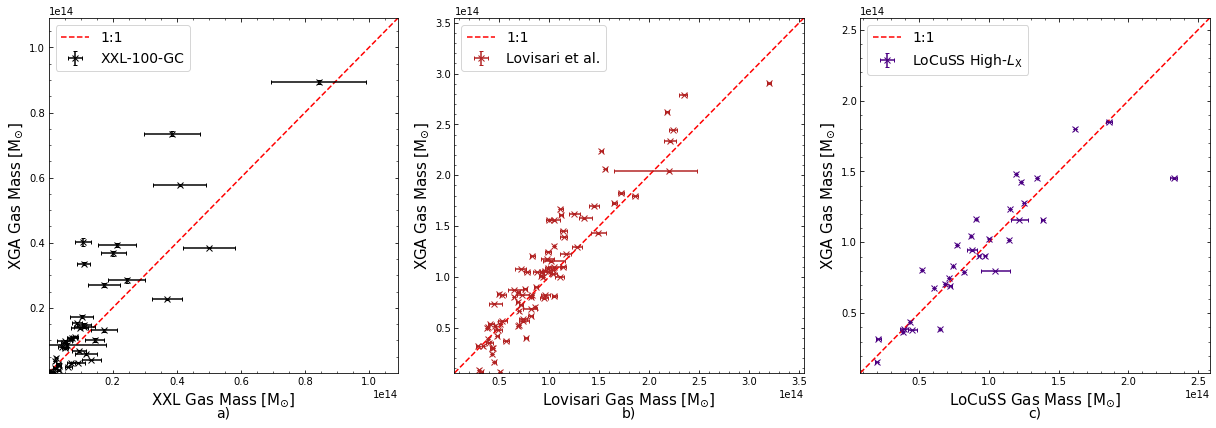

In [27]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_dblbeta_svikh_13_gm[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()

## Gas Density Profile Generation and Comparison to Literature - from Annular Spectra

### Simplified Vikhlinin Profiles - out to $R_{500}$

In [ ]:
loc_annspec_10_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500, min_snr=30)
lov_annspec_10_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500, min_snr=30)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_1r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_10_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_10_dp)) as onwards:
    for dp in lov_annspec_10_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_10_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_10_dp)) as onwards:
    for dp in loc_annspec_10_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_10_annspec_gm = Quantity(lov_svikh_10_annspec_gm, 'Msun').astype(float)
loc_svikh_10_annspec_gm = Quantity(loc_svikh_10_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_10_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_10_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_10_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_10_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

plt.tight_layout()

# Saving and plotting the resulting figure
plt.savefig("non_paper_figures/lov_loc_svikh_1r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [ ]:
loc_annspec_13_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.3, min_snr=30)
lov_annspec_13_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.3, min_snr=30)

In [ ]:
lov_annspec_13_dp = [None]*len(lovisari_srcs)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_13r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_13_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_13_dp)) as onwards:
    for dp in lov_annspec_13_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_13_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_13_dp)) as onwards:
    for dp in loc_annspec_13_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_13_annspec_gm = Quantity(lov_svikh_13_annspec_gm, 'Msun').astype(float)
loc_svikh_13_annspec_gm = Quantity(loc_svikh_13_annspec_gm, 'Msun').astype(float)

In [ ]:
rel_src = locuss_srcs[loc_annspec_13_dp[0].src_name]
loc_annspec_13_dp[0].view(draw_rads={'$R_{500}$': rel_src.r500}, xscale='linear')

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_13_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_13_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_13_annspec_gm).value
loc_lims[1] = 0.5e+15
# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_13_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_13r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.2$R_{500}$ 

In [ ]:
loc_annspec_12_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.2, min_snr=30)
lov_annspec_12_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.2, min_snr=30)

In [ ]:
lov_annspec_12_dp = [None]*len(lovisari_srcs)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_12r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_12_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_12_dp)) as onwards:
    for dp in lov_annspec_12_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_12_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_12_dp)) as onwards:
    for dp in loc_annspec_12_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_12_annspec_gm = Quantity(lov_svikh_12_annspec_gm, 'Msun').astype(float)
loc_svikh_12_annspec_gm = Quantity(loc_svikh_12_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_12_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_12_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_12r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.05$R_{500}$

In [ ]:
loc_annspec_105_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.05, min_snr=30)
lov_annspec_105_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.05, min_snr=30)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_105r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_105_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_105_dp)) as onwards:
    for dp in lov_annspec_105_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_105_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_105_dp)) as onwards:
    for dp in loc_annspec_105_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_105_annspec_gm = Quantity(lov_svikh_105_annspec_gm, 'Msun').astype(float)
loc_svikh_105_annspec_gm = Quantity(loc_svikh_105_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_105_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_105_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_105_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_105_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.show()